<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-01/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 01: Logistic Regression
## Author: Colin Scherer

### **Task 1: Advanced Objective Function and Use Case**
1. For logistic regression, the predicted outcome is given by: $$\hat{y}=\frac{1}{1+e^{-(w^Tx+b)}}$$ Using MLE, parameters are chosen such that $\mathcal{P}(D|\theta)$ (the likelihood) is maximized. Here, $$\mathcal{P}(D|\theta)=\prod_{i=1}^{N}\mathcal{P}(y_i|x_i,\theta)$$ Using the predicted outcome for logistic regression, we can see that $$\mathcal{P}(y_i|x_i,w,b)=\begin{cases}\hat{y}_i & y_i=1\\1-\hat{y}_i & y_i=0\end{cases}$$ This can be unified into the expression $$\mathcal{P}(y_i|x_i,w,b)=\hat{y}_{i}^{y_i}(1-\hat{y}_i)^{1-y_i}$$Now, $$\begin{align}\mathcal{P}(D|w,b)=\prod_{i=1}^N\hat{y}_{i}^{y_i}(1-\hat{y}_i)^{1-y_i}\\=\sum_{i=1}^{N}y_i\log{\hat{y}_{i}}+(1-y_i)\log{(1-\hat{y}_i)}\end{align}$$This is our objective function to maximize with respect to the parameters $w$ and $b$. In order to get this into a cost function, we can multiply it by $-1$ and choose to optimize the parameters with the goal of minimizing instead.
In MLE, we are maximizing the likelihood that the data appears the way it does by estimating the parameters. In contrast, we are doing the opposite in MAP: maximizing the likelihood of the weights given the data, which can be a bit more intuitive. One caveat of this method is that we can only have one term to maximize, $\mathbf{w}$, so $b$ gets absorbed as an extra dimensionn of $\mathbf{w}$. We also must assume a prior for $\mathbf{w}$, so that we then get: $$\mathcal{P}(\mathbf{w}|D)∝\mathcal{P}(D|\mathbf{w})\mathcal{P}(\mathbf{w})$$Sources: [Cornell CS4780](https://www.cs.cornell.edu/courses/cs4780/2015fa/web/lecturenotes/lecturenote06.html), [machinelearningmastery](https://machinelearningmastery.com/maximum-a-posteriori-estimation/)

2. For this problem, I've chosen to solve the problem of predicting whether or not a person has heart disease, given their general demographic information as well as some health information. As logistic regression is highly interpretable, simple, and relatively fast, it's the best option for this problem. It also doesn't require independent features, which is an assumption that the Naive Bayes classifier makes. Since this dataset has absolutely no guarantees of independence, this is a huge advantage towards logistic regression.

3. For the $i$th patient in the dataset, their features such as age, gender, resting heart rate, heart pain, and so on are $\mathbf{x}_i$ (the input feature vector). $y_i$ corresponds to whether or not the patient has heart disease (0 for no, and 1 for yes); in the derivation above I'm assuming that this is a boolean variable, so this should only be a one or zero. Similarly, my predicted value for the $i$th patient should also be a one or zero, and corresponds to $\hat{y}_i$ in the derivation above.


### **Task 2: Dataset and Advanced Exploratory Data Analysis**
1. [Here](https://www.kaggle.com/datasets/jocelyndumlao/cardiovascular-disease-dataset/data) is a link to the chosen dataset.

2. Continued below is my exploratory data analysis.


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import pandas as pd
from sys import stderr
import time

df = pd.read_csv("sample_data/Cardiovascular_Disease_Dataset.csv")
print(df.columns)

Index(['patientid', 'age', 'gender', 'chestpain', 'restingBP',
       'serumcholestrol', 'fastingbloodsugar', 'restingrelectro',
       'maxheartrate', 'exerciseangia', 'oldpeak', 'slope', 'noofmajorvessels',
       'target'],
      dtype='object')


Patient IDs get removed from the dataset since they have no correlation with risk of cardiovascular disease, and are mainly an administrative feature. The targets also get removed from the DataFrame and stored separately -- inclusion of them during the exploratory data analysis could exaggerate the VIFs of features.

In [35]:
ids = df.pop('patientid')
target = np.array([df.pop('target')]).T
print(np.shape(target))


(1000, 1)


In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for i, feature in enumerate(df.columns):
  print("{f}:\t\t\t{v}".format(f=feature, v=variance_inflation_factor(df, i)))

age:			7.407596355598797
gender:			4.817933196275213
chestpain:			2.769973247824231
restingBP:			19.55819546809747
serumcholestrol:			6.841283732242029
fastingbloodsugar:			1.6315144635671195
restingrelectro:			2.2752069549785627
maxheartrate:			15.31373507529977
exerciseangia:			1.9573909458166356
oldpeak:			4.107704856254519
slope:			6.588687713546299
noofmajorvessels:			3.6221891064620224


From this analysis, it seems that resting blood pressure and maximum heart rate have fairly high correlations when compared to the other variables. Since I have 12 features here, I will opt to remove two features with high VIFs one-by-one and see how the correlations change. First, I'll remove resting blood pressure, since it has the highest VIF initially.

In [37]:
resting_bp = df.pop('restingBP')

for i, feature in enumerate(df.columns):
  print("{f}:\t\t\t{v}".format(f=feature, v=variance_inflation_factor(df, i)))

age:			6.745661706317401
gender:			4.729826309380826
chestpain:			2.7699464255257977
serumcholestrol:			6.362133940135387
fastingbloodsugar:			1.631511412559225
restingrelectro:			2.2583620824477695
maxheartrate:			11.808640016186857
exerciseangia:			1.9463571130839614
oldpeak:			4.103352613885141
slope:			6.336141070493396
noofmajorvessels:			3.6027944594356818


The VIF for maximum heart rate went down by 4, indicating a high correlation between maximum heart rate and resting blood pressure. However, it still has a VIF of 11.8, so it shouldn't be included in our features either.

In [38]:
max_hr = df.pop('maxheartrate')

for i, feature in enumerate(df.columns):
  print("{f}:\t\t\t{v}".format(f=feature, v=variance_inflation_factor(df, i)))

age:			5.686277184765438
gender:			4.227614439981985
chestpain:			2.7694304226972553
serumcholestrol:			5.649147368369337
fastingbloodsugar:			1.6290097941735278
restingrelectro:			2.2479079642202655
exerciseangia:			1.8834310429853967
oldpeak:			4.075928021236269
slope:			6.053960449484661
noofmajorvessels:			3.59784976520211


According to [this source](https://www.investopedia.com/terms/v/variance-inflation-factor.asp#:~:text=A%20variance%20inflation%20factor%20(VIF)%20is%20a%20measure%20of%20the,adversely%20affect%20the%20regression%20results.), a VIF greater than 5 implies that variables are highly correlated and a score greater than 10 means that the multicollinearity must be corrected. While multiple features with VIFs greater than 5 are present in this dataset, no features have a VIF greater than 6.05, which I would consider at least passable. Since I've reduced the amount of features down to exactly 10, I will continue without removing any other features, although these relatively high correlations are something to keep in mind.

<Axes: >

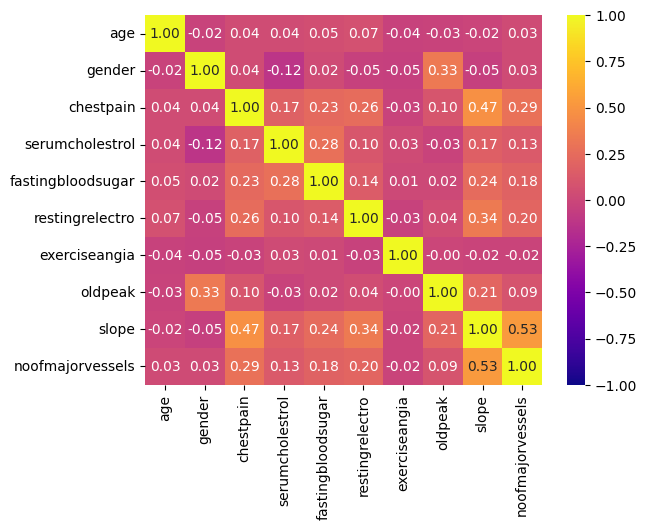

In [39]:
import seaborn
from scipy.stats import linregress

corr = df.corr()

seaborn.heatmap(corr, annot=True, fmt=".2f", cmap='plasma', vmin=-1)

From this, it seems that slope has the highest correlation with other variables, since its row/column appears to have the most orange. This makes sense, as "slope" refers to the slope change in the ST segment of an EKG during exercise, and has been [shown to be a major indicator of heart disease](https://www.sciencedirect.com/science/article/abs/pii/0002870386902656).

With this heatmap being a bit messy, the following code clusters the features by intensity. As I've never done heatmap clustering before, this code was taken directly from [Chinoy Sen on kaggle](https://www.kaggle.com/code/chinoysen/beginners-guide-to-heatmaps-cluster-heatmap).

<Axes: >

<Figure size 1200x500 with 0 Axes>

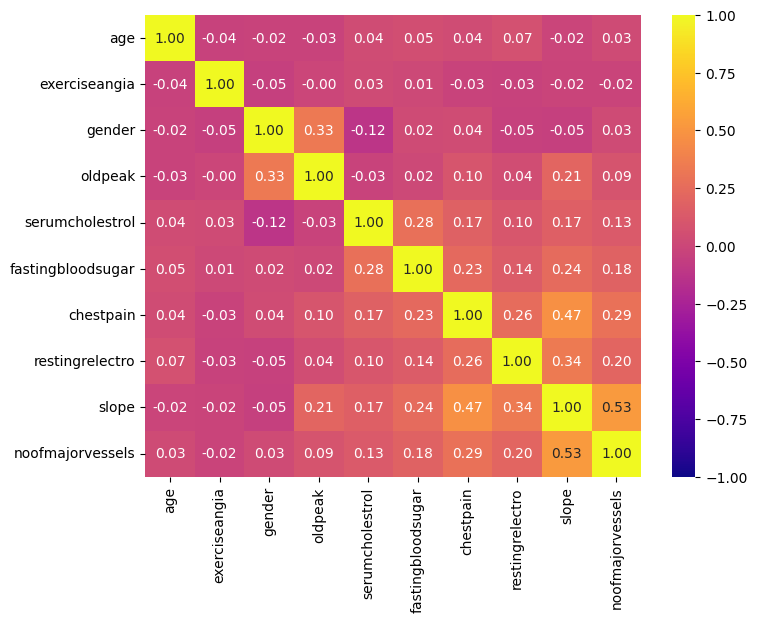

In [40]:
# TAKEN FROM https://www.kaggle.com/code/chinoysen/beginners-guide-to-heatmaps-cluster-heatmap

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity=1- abs(corr)
Z=linkage(squareform(dissimilarity), 'complete')

# dendrogram(Z, labels=df.columns, orientation='top', leaf_rotation=90)

threshold= 0.8
labels=fcluster(Z, threshold, criterion='distance')

labels_order = np.argsort(labels)

#Build a new dataframe with the sorted columns
for idx, i in enumerate(df.columns[labels_order]):
    if idx==0:
        clustered=pd.DataFrame(df[i])
    else:
        df_to_append = pd.DataFrame(df[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(8,6))
seaborn.heatmap(clustered.corr(), vmin=-1, vmax=1, cmap='plasma', annot=True, fmt=".2f")

As expected, slope is one of the last features, and four of the most likely suspects at determining heart disease are the last features: number of blood vessels refers to how many blood vessels are visible in the heart with fluoroscopy, depending on how blocked the heart is; restingrelectro refers to severity of abnormality in the EKG trace at rest. While intuitively age should influence risk of heart disease, this dataset was gathered from a hospital, where presumably the patients were already experiencing issues. If a random sample from the population was gathered instead, I'm sure there would be more of a correlation between age and these features.

Below is another visualization of the features -- pairplots with KDE.

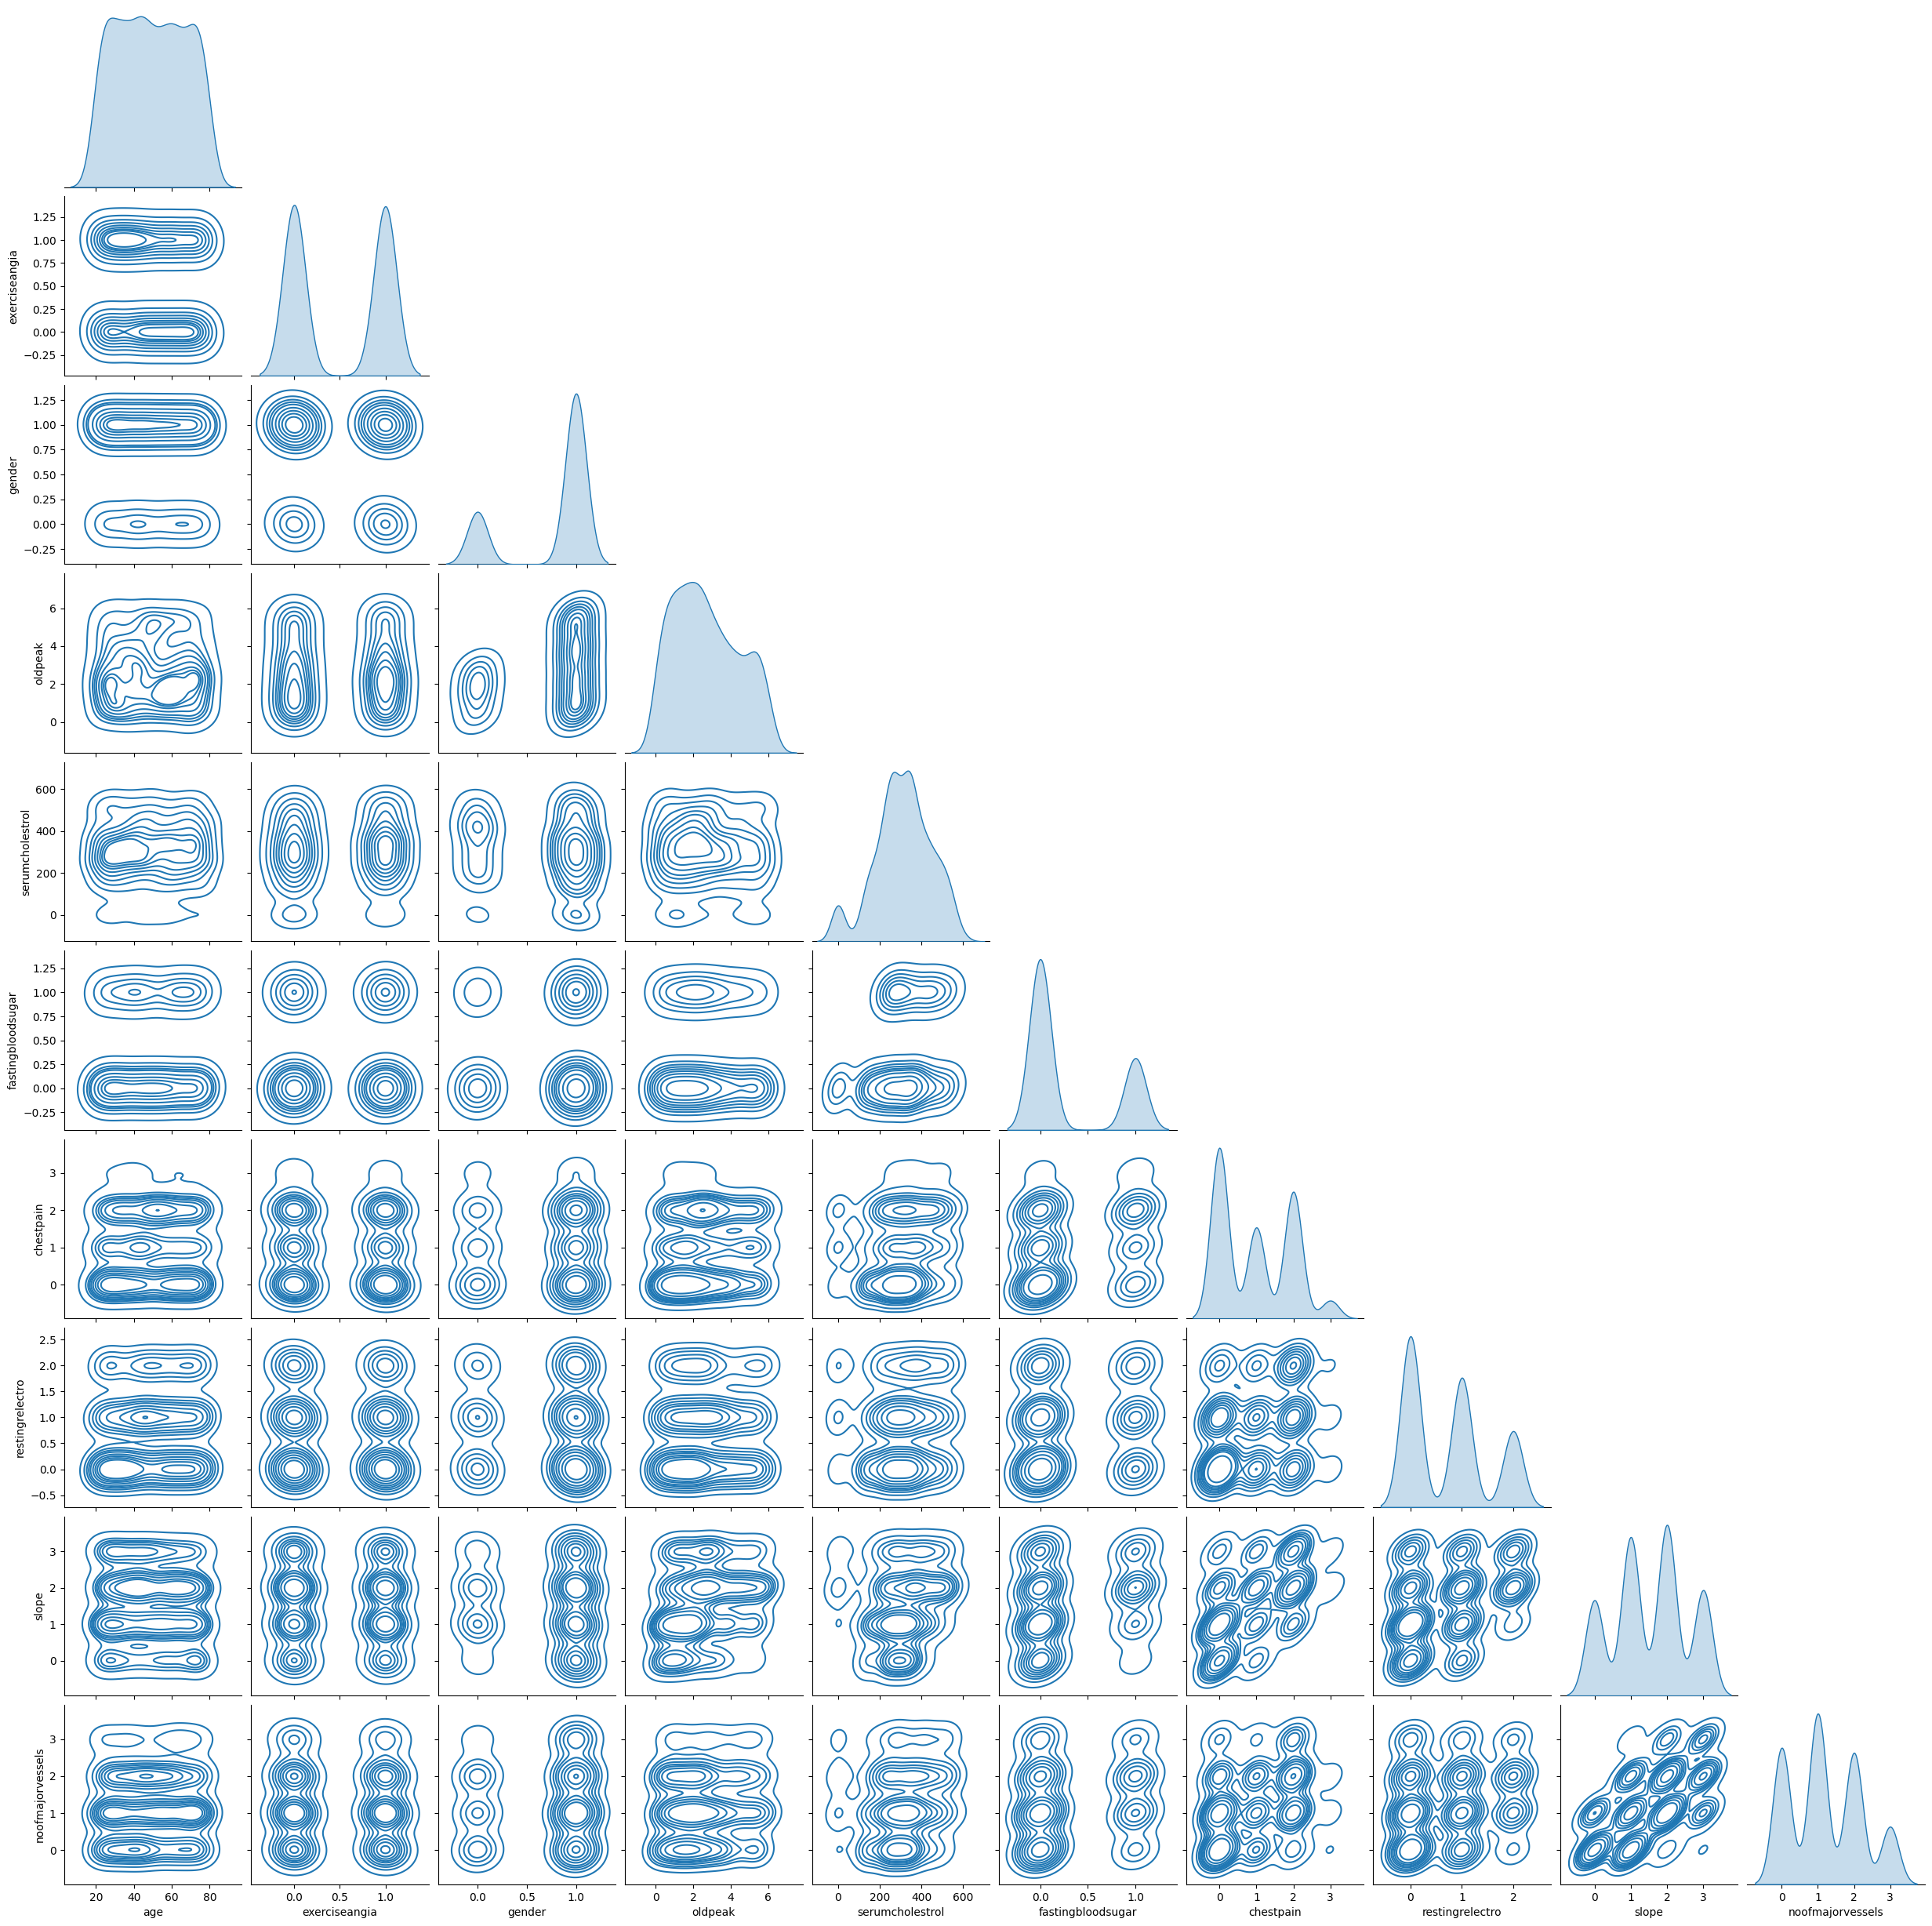

In [41]:
seaborn.pairplot(clustered, kind="kde", corner=True)

Interestingly, gender is heavily skewed towards male here, rather than being balanced as expected in a general population sample -- this brings some doubt into the quality of bias in this dataset, but it shouldn't be too much of an issue for a basic logistic regression task. Towards the bottom right of these pairplots, we can see the strong positive linear correlations between slope and number of blood vessels. However, other than a few clear correlations, the variables seem relatively uniformlu distributed relative to each other.

### **Task 3: Logistic Regression Implementation**

Below is my implementation of gradient descent for logistic regression.

In [42]:
def calc_error(data, target, W, b):
  return np.mean(np.abs(np.round(1/(1+np.exp(-1*(np.matmul(W.T, data)+b))).T-target)))

def calc_loss(target, predicted):
  return -(target*np.log(predicted+0.0000001)+(1-target)*np.log(1.0000001-predicted))

def predict(data, W, b):
  return np.round(1/(1+np.exp(-1*(np.matmul(W.T, data)+b))).T)

# Perform gradient descent. Use B=1 for stochastic, 1<B<N for mini-batch, or B=N for batch
def grad_desc(tar_train, train, tar_valid, valid, B=1, epochs=10000, eta=0.0005, early_stop=500, optimizer = "default", gamma = 0.7, beta1 = 0.9, beta2=0.999, epsilon=10e-8):
  rng = np.random.default_rng()

  W = np.ones((train.shape[1], 1))*rng.normal(0, 0.05, (train.shape[1], 1))
  Wbest = W
  b = np.abs(rng.normal(0, 0.1))
  bbest = b
  X = np.array(train).T
  errs = np.array([])
  losses = []
  prev_loss = 1.0
  since_best = 0

  prev_W = np.zeros(np.shape(W))
  prev_b = 0
  prev_Wm = np.zeros(np.shape(W))
  prev_bm = 0

  for e in range(epochs):
    indices = np.random.permutation(train.shape[0])
    for i in range(0, train.shape[0], B):
      Xbatch = X[:,indices[i:i+B]]
      tarbatch = tar_train[indices[i:i+B]]
      ybatch = 1/(1+np.exp(-1*(np.matmul(W.T,Xbatch)+b))).T
      gradW = (1/B)*(np.matmul(Xbatch, (ybatch-tarbatch)))
      gradb = (1/B)*(np.sum(ybatch-tarbatch))

      if(optimizer == "default"):
        W = W - eta*gradW
        b = b - eta*gradb
      elif(optimizer == "momentum"):
        W -= (gamma*prev_W + eta*gradW)
        b -= (gamma*prev_b + eta*gradb)
        prev_W = gamma*prev_W + eta*gradW
        prev_b = gamma*prev_b + eta*gradb
      elif(optimizer == "RMSprop"):
        wg_sq = 0.9*prev_W+0.1*(gradW**2)
        bg_sq = 0.9*prev_b+0.1*(gradb**2)
        W -= (eta/(np.sqrt(wg_sq+epsilon)))*gradW
        b -= (eta/(np.sqrt(bg_sq+epsilon)))*gradb
        prev_W = wg_sq
        prev_b = bg_sq
      elif(optimizer == "Adam"):
        mW = beta1*prev_Wm + (1-beta1)*gradW
        mb = beta1*prev_bm + (1-beta1)*gradb
        vW = beta2*prev_W + (1-beta2)*(gradW**2)
        vb = beta2*prev_b + (1-beta2)*(gradb**2)
        t = e*(train.shape[0]//B)+(i+1)
        mW_adj = mW/(1-(beta1**t))
        mb_adj = mb/(1-(beta1**t))
        vW_adj = vW/(1-(beta2**t))
        vb_adj = vb/(1-(beta2**t))
        W -= (eta/(np.sqrt(vW_adj)+epsilon))*mW_adj
        b -= (eta/(np.sqrt(vb_adj)+epsilon))*mb_adj
        prev_Wm = mW
        prev_bm = mb
        prev_W = vW
        prev_b = vb

      else:
        print("Unknown optimizer requested.", file=stderr)

    yhat = 1/(1+np.exp(-1*(np.matmul(W.T,X)+b))).T
    loss = calc_loss(tar_train, yhat)
    losses.append(np.mean(loss))

    # Perform early stopping using validation set
    if(e%10 == 0):
      pred_val = 1/(1+np.exp(-1*(np.matmul(W.T,np.array(valid).T)+b))).T
      val_loss = calc_loss(tar_valid, pred_val)
      if np.mean(val_loss) > prev_loss:
        since_best += 1
      else:
        Wbest = W
        bbest = b
        prev_loss = np.mean(val_loss)
        since_best = 0
      errs = np.append(errs, np.mean(val_loss))
      if(since_best >= early_stop/10):
        break

  return Wbest, bbest, errs, losses


def tune_hyperparams(optimizer, train_target, train_data, valid_target, valid_data, **kwargs):
  if(len(kwargs) > 2):
    print("Only tune 1-2 hyperparameters at once.", file=stderr)
    return

  num_params = len(list(kwargs.keys()))
  k1 = list(kwargs.keys())[0]
  if(num_params > 1):
    k2 = list(kwargs.keys())[1]
  param1_best = 0
  param2_best = 0
  f1best = 0
  for v1 in kwargs[k1]:
    if(num_params > 1):
      for v2 in kwargs[k2]:
        if(k2 == "early_stop"):
          W, b, _, _ = grad_desc(train_target, train_data, valid_target, valid_data, optimizer=optimizer, eta=v1, early_stop=v2)
        elif(k2 == "gamma"):
          W, b, _, _ = grad_desc(train_target, train_data, valid_target, valid_data, optimizer=optimizer, eta=v1, gamma=v2)
        elif(k2 == "beta1"):
          W, b, _, _ = grad_desc(train_target, train_data, valid_target, valid_data, optimizer=optimizer, eta=v1, beta1=v2)
        if(f1_score(valid_target, predict(valid_data.T, W, b))>f1best):
          param1_best = v1
          param2_best = v2
          f1best = f1_score(valid_target, predict(valid_data.T, W, b))
    else:
      W, b, _, _ = grad_desc(train_target, train_data, valid_target, valid_data, optimizer=optimizer, eta=v1)
      if(f1_score(valid_target, predict(valid_data.T, W, b))>f1best):
        param1_best = v1
        f1best = f1_score(valid_target, predict(valid_data.T, W, b))

  return param1_best, param2_best, f1best


Test error for batch grad descent: 0.19
Time to complete batch grad descent: 2.35 seconds
Test error for minibatch grad descent: 0.075
Time to complete minibatch grad descent: 16.13 seconds
Test error for stochastic grad descent: 0.12
Time to complete stochastic grad descent: 22.59 seconds


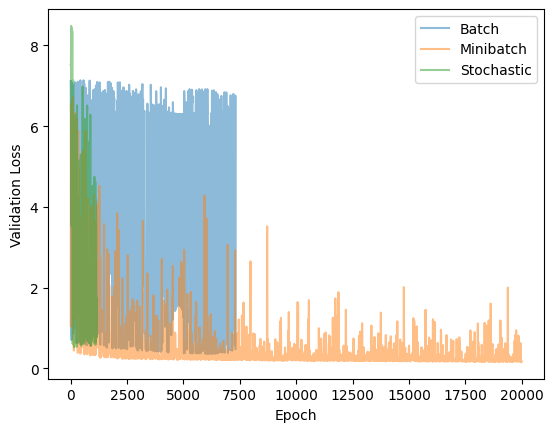

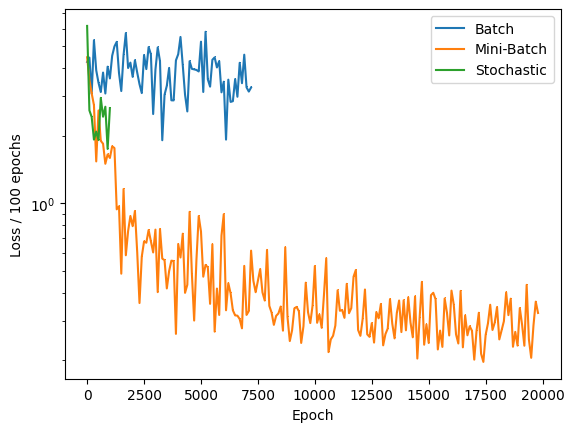

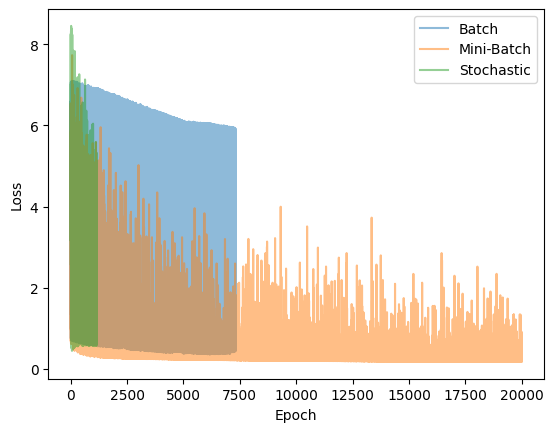

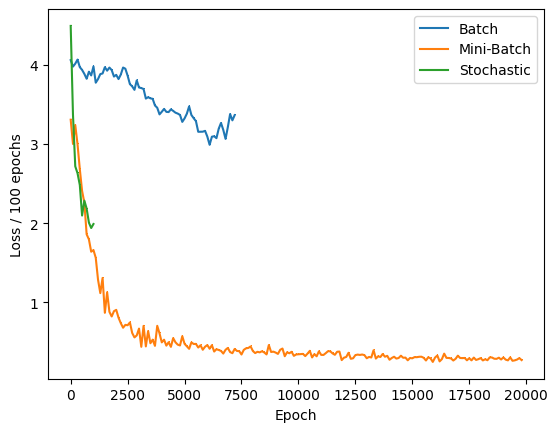

In [43]:
# Default hyperparameters
epochs = 20000
eta = 0.0005
early_stop = 1000
batch_size = 32
gamma = 0.7

# Split dataset into training, validation, and test at a ratio of 3:1:1.
np.random.shuffle(np.array(df))
train_data = df[:int(df.shape[0]*0.6)]
train_target = target[:int(df.shape[0]*0.6)]
valid_data = np.array(df[int(df.shape[0]*0.6):int(df.shape[0]*0.8)])
valid_target = np.array(target[int(df.shape[0]*0.6):int(df.shape[0]*0.8)])
test_data = df[int(df.shape[0]*0.8):]
test_target = target[int(df.shape[0]*0.8):]

start = time.time()
W, b, val_losses_batch, lossesBatch = grad_desc(train_target, train_data, valid_target, valid_data, train_data.shape[0], epochs, eta, early_stop)
end = time.time()

print("Test error for batch grad descent: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete batch grad descent: {:.2f} seconds".format(end-start))
plt.plot(np.arange(0, np.shape(val_losses_batch)[0]*10, 10), val_losses_batch, label="Batch", alpha=0.5)

start = time.time()
W, b, val_losses_mini, lossesMini = grad_desc(train_target, train_data, valid_target, valid_data, batch_size, epochs, eta, early_stop)
end = time.time()

print("Test error for minibatch grad descent: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete minibatch grad descent: {:.2f} seconds".format(end-start))
plt.plot(np.arange(0, np.shape(val_losses_mini)[0]*10, 10), val_losses_mini, label="Minibatch", alpha=0.5)

start = time.time()
W, b, val_losses_stoch, lossesStoch = grad_desc(train_target, train_data, valid_target, valid_data, 1, epochs, eta, early_stop)
end = time.time()

print("Test error for stochastic grad descent: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete stochastic grad descent: {:.2f} seconds".format(end-start))
plt.plot(np.arange(0, np.shape(val_losses_stoch)[0]*10, 10), val_losses_stoch, label="Stochastic", alpha=0.5)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot()
plt.show()

avg_losses_batch = np.array([np.mean(val_losses_batch[i-10:i]) for i in range(10, len(val_losses_batch), 10)])
avg_losses_mini = np.array([np.mean(val_losses_mini[i-10:i]) for i in range(10, len(val_losses_mini), 10)])
avg_losses_stoch = np.array([np.mean(val_losses_stoch[i-10:i]) for i in range(10, len(val_losses_stoch), 10)])
plt.plot(np.arange(0, len(avg_losses_batch))*100, avg_losses_batch, label="Batch", marker=",")
plt.plot(np.arange(0, len(avg_losses_mini))*100, avg_losses_mini, label="Mini-Batch", marker=",")
plt.plot(np.arange(0, len(avg_losses_stoch))*100, avg_losses_stoch, label="Stochastic", marker=",")
plt.ylabel("Loss / 100 epochs")
plt.yscale("log")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(np.arange(0, len(lossesBatch)), lossesBatch, label="Batch", alpha=0.5)
plt.plot(np.arange(0, len(lossesMini)), lossesMini, label="Mini-Batch", alpha=0.5)
plt.plot(np.arange(0, len(lossesStoch)), lossesStoch, label="Stochastic", alpha=0.5)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

avg_costs_batch = np.array([np.mean(lossesBatch[i-100:i]) for i in range(100, len(lossesBatch), 100)])
avg_costs_mini = np.array([np.mean(lossesMini[i-100:i]) for i in range(100, len(lossesMini), 100)])
avg_costs_stoch = np.array([np.mean(lossesStoch[i-100:i]) for i in range(100, len(lossesStoch), 100)])


plt.plot(np.arange(0, len(avg_costs_batch))*100, avg_costs_batch, label="Batch", marker=",")
plt.plot(np.arange(0, len(avg_costs_mini))*100, avg_costs_mini, label="Mini-Batch", marker=",")
plt.plot(np.arange(0, len(avg_costs_stoch))*100, avg_costs_stoch, label="Stochastic", marker=",")
plt.ylabel("Loss / 100 epochs")
# plt.yscale("log")
plt.xlabel("Epoch")
plt.legend()
plt.show()


Here, we can see that batch gradient descent clearly converges significantly slower than stochastic or mini-batch gradient descent, and fails to reach as low a minimum as the other two methods. However, batch terminates about 5x faster than mini-batch descent, and about 15x faster than stochastic descent. This difference is likely due to the amount of updates per epoch -- while batch descent makes only 1 update per epoch, mini-batch makes $\frac{600}{32}\approx 18$ updates per epoch, and stochastic makes 600 updates per epoch. Thus, batch is actually the slowest method when comparing the time per weight update.

There is also a significant difference in the performance between stochastic and mini-batch gradient descent. One important thing to note in the loss graphs above is that stochastic gradient descent terminates well before mini-batch gradient descent, and fails to reach a loss as low as mini-batch does.

I think, given these options, mini-batch seems to be the clear best choice for gradient descent algorithms (at least for this particular problem), as it reaches a lower loss value, leads to a better test error, and takes a reasonable amount of time.

### **Task 4: Optimization Techniques and Advanced Comparison**
1. All optimization techniques were implemented within the initial function. Below, gradient descent is called with each optimization algorithm and the results are compared to vanilla gradient descent.


In [44]:
# Default hyperparameters
epochs = 20000
eta = 0.0005
early_stop = 500
batch_size = 32
gamma = 0.7 # Gamma = 0.7 instead of 0.9 is used in an attempt to decrease the chance of overflow

# Split dataset into training, validation, and test at a ratio of 3:1:1.
np.random.shuffle(np.array(df))
train_data = df[:int(df.shape[0]*0.6)]
train_target = target[:int(df.shape[0]*0.6)]
valid_data = np.array(df[int(df.shape[0]*0.6):int(df.shape[0]*0.8)])
valid_target = np.array(target[int(df.shape[0]*0.6):int(df.shape[0]*0.8)])
test_data = df[int(df.shape[0]*0.8):]
test_target = target[int(df.shape[0]*0.8):]

start = time.time()
W, b, val_losses_stoch, lossesStoch = grad_desc(train_target, train_data, valid_target, valid_data, 1, epochs, eta, early_stop)
end = time.time()
print("Test error for stochastic grad descent: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete stochastic grad descent: {:.2f} seconds".format(end-start))
print("Precision score for stochastic gradient descent: {}".format(precision_score(test_target, predict(test_data.T, W, b))))
print("Recall score for stochastic gradient descent: {}".format(recall_score(test_target, predict(test_data.T, W, b))))
print("F1 score for stochastic gradient descent: {}".format(f1_score(test_target, predict(test_data.T, W, b))))
print()

start = time.time()
W, b, val_losses_mom, lossesMom = grad_desc(train_target, train_data, valid_target, valid_data, 1, epochs, eta, early_stop, optimizer="momentum", gamma=gamma)
end = time.time()
print("Test error for grad descent with momentum: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete grad descent with momentum: {:.2f} seconds".format(end-start))
print("Precision score for grad descent with momentum: {}".format(precision_score(test_target, predict(test_data.T, W, b))))
print("Recall score for grad descent with momentum: {}".format(recall_score(test_target, predict(test_data.T, W, b))))
print("F1 score for gradient descent with momentum: {}".format(f1_score(test_target, predict(test_data.T, W, b))))
print()


start = time.time()
W, b, val_losses_RMS, lossesRMS = grad_desc(train_target, train_data, valid_target, valid_data, 1, epochs, eta, early_stop, optimizer="RMSprop")
end = time.time()
print("Test error for grad descent with RMSprop: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete grad descent with RMSprop: {:.2f} seconds".format(end-start))
print("Precision score for grad descent with RMSprop: {}".format(precision_score(test_target, predict(test_data.T, W, b))))
print("Recall score for grad descent with RMSprop: {}".format(recall_score(test_target, predict(test_data.T, W, b))))
print("F1 score for gradient descent with RMSprop: {}".format(f1_score(test_target, predict(test_data.T, W, b))))
print()

start = time.time()
W, b, val_losses_adam, lossesAdam = grad_desc(train_target, train_data, valid_target, valid_data, 1, epochs, eta, early_stop, optimizer="Adam")
end = time.time()
print("Test error for grad descent with adam: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete grad descent with adam: {:.2f} seconds".format(end-start))
print("Precision score for grad descent with adam: {}".format(precision_score(test_target, predict(test_data.T, W, b))))
print("Recall score for grad descent with adam: {}".format(recall_score(test_target, predict(test_data.T, W, b))))
print("F1 score for gradient descent with adam: {}".format(f1_score(test_target, predict(test_data.T, W, b))))
print()


Test error for stochastic grad descent: 0.095
Time to complete stochastic grad descent: 19.23 seconds
Precision score for stochastic gradient descent: 0.940677966101695
Recall score for stochastic gradient descent: 0.9024390243902439
F1 score for stochastic gradient descent: 0.921161825726141

Test error for grad descent with momentum: 0.075
Time to complete grad descent with momentum: 58.36 seconds
Precision score for grad descent with momentum: 0.921875
Recall score for grad descent with momentum: 0.959349593495935
F1 score for gradient descent with momentum: 0.9402390438247012

Test error for grad descent with RMSprop: 0.065
Time to complete grad descent with RMSprop: 76.83 seconds
Precision score for grad descent with RMSprop: 0.9435483870967742
Recall score for grad descent with RMSprop: 0.9512195121951219
F1 score for gradient descent with RMSprop: 0.9473684210526315

Test error for grad descent with adam: 0.05
Time to complete grad descent with adam: 108.30 seconds
Precision sco

From this, both adam and RMSprop optimization algorithms seem to take significantly longer than momentum and vanilla stochastic gradient descent. However, this is mainly because validation loss steadily continues decreasing with Adam and RMSprop, meaning a good minimum is much more likely to be found before early stopping. With momentum and vanilla gradient descent, the validation loss fluctuates significantly, meaning early stopping is very likely to trigger earlier, since the decreases in validation loss are more sporadic. If my early stopping threshold was larger, momentum and vanilla would have similarly high computation times.

Surprisingly, the F1 score using momentum is lower than the F1 score using vanilla gradient descent about half the time. My guess for this is that there may be a dramatic shift in the gradient, which means the "snowballing" of the momentum optimization algorithm actually leads to overshooting a minimum, and ends up in an area that vanilla gradient descent doesn't ever go. Also, my recall / precision scores sometimes end up being exactly 1.0 in my momentum algorithm, which is suspicious to me -- it may mean my implementation is not correct somehow.

On the other hand, my F1 scores for RMSprop and Adam are as expected -- they usually have F1 scores about 0.02-0.05 higher than vanilla gradient descent.

Below is code plotting the validation and training losses of all algorithms per epoch, as well as averaged over 100 epochs to account for noisy values. In general, the results are very unsurprising -- adam converges slightly faster than RMSprop, and they both converge significantly faster than vanilla gradient descent and gradient descent with momentum.

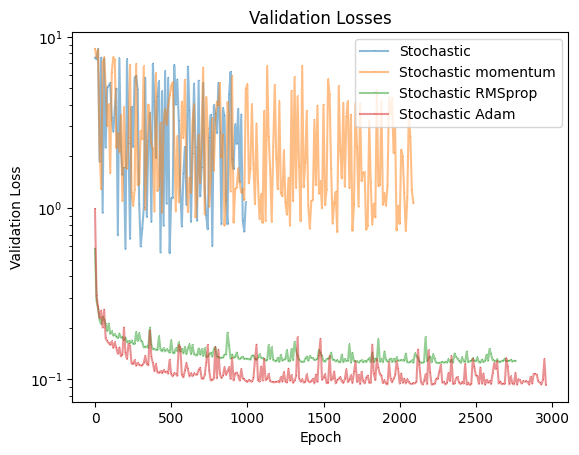

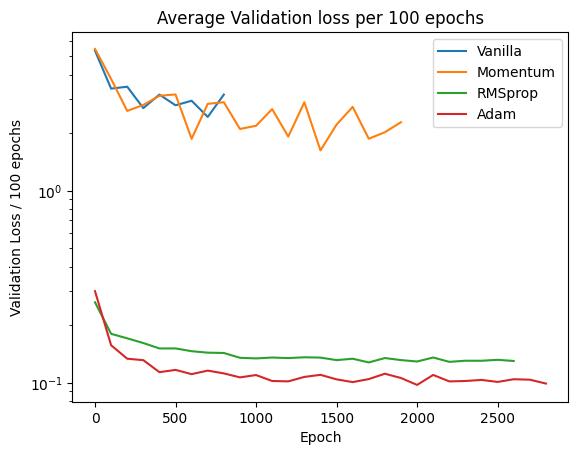

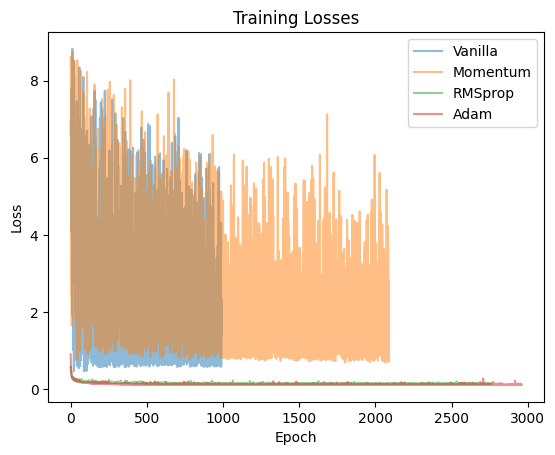

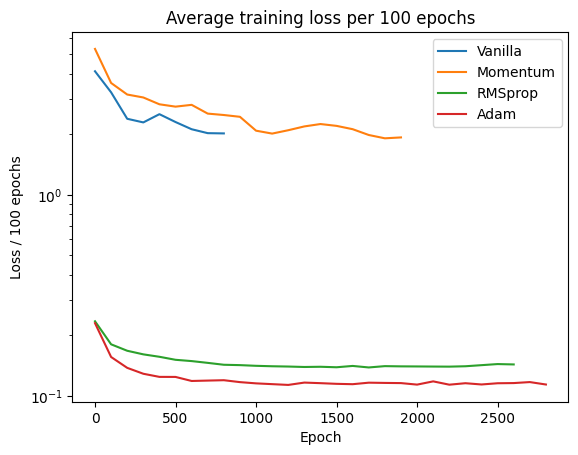

In [45]:
plt.plot(np.arange(0, np.shape(val_losses_stoch)[0]*10, 10), val_losses_stoch, label="Stochastic", marker=",", alpha=0.5)
plt.plot(np.arange(0, np.shape(val_losses_mom)[0]*10, 10), val_losses_mom, label="Stochastic momentum", marker=",", alpha=0.5)
plt.plot(np.arange(0, np.shape(val_losses_RMS)[0]*10, 10), val_losses_RMS, label="Stochastic RMSprop", marker=",", alpha=0.5)
plt.plot(np.arange(0, np.shape(val_losses_adam)[0]*10, 10), val_losses_adam, label="Stochastic Adam", marker=",", alpha=0.5)
plt.legend()
plt.title("Validation Losses")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()



avg_losses_stoch = np.array([np.mean(val_losses_stoch[i-10:i]) for i in range(10, len(val_losses_stoch), 10)])
avg_losses_mom = np.array([np.mean(val_losses_mom[i-10:i]) for i in range(10, len(val_losses_mom), 10)])
avg_losses_rms = np.array([np.mean(val_losses_RMS[i-10:i]) for i in range(10, len(val_losses_RMS), 10)])
avg_losses_adam = np.array([np.mean(val_losses_adam[i-10:i]) for i in range(10, len(val_losses_adam), 10)])
plt.plot(np.arange(0, len(avg_losses_stoch)*100, 100), avg_losses_stoch, label="Vanilla")
plt.plot(np.arange(0, len(avg_losses_mom)*100, 100), avg_losses_mom, label="Momentum")
plt.plot(np.arange(0, len(avg_losses_rms)*100, 100), avg_losses_rms, label="RMSprop")
plt.plot(np.arange(0, len(avg_losses_adam)*100, 100), avg_losses_adam, label="Adam")
plt.title("Average Validation loss per 100 epochs")
plt.ylabel("Validation Loss / 100 epochs")
plt.xlabel("Epoch")
plt.yscale("log")
plt.legend()
plt.show()



plt.plot(np.arange(0, len(lossesStoch)), lossesStoch, label="Vanilla", alpha=0.5)
plt.plot(np.arange(0, len(lossesMom)), lossesMom, label="Momentum", alpha=0.5)
plt.plot(np.arange(0, len(lossesRMS)), lossesRMS, label="RMSprop", alpha=0.5)
plt.plot(np.arange(0, len(lossesAdam)), lossesAdam, label="Adam", alpha=0.5)
plt.title("Training Losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()



avg_losses_stoch = np.array([np.mean(lossesStoch[i-100:i]) for i in range(100, len(lossesStoch), 100)])
avg_losses_mom = np.array([np.mean(lossesMom[i-100:i]) for i in range(100, len(lossesMom), 100)])
avg_losses_rms = np.array([np.mean(lossesRMS[i-100:i]) for i in range(100, len(lossesRMS), 100)])
avg_losses_adam = np.array([np.mean(lossesAdam[i-100:i]) for i in range(100, len(lossesAdam), 100)])
plt.plot(np.arange(0, len(avg_losses_stoch)*100, 100), avg_losses_stoch, label="Vanilla")
plt.plot(np.arange(0, len(avg_losses_mom)*100, 100), avg_losses_mom, label="Momentum")
plt.plot(np.arange(0, len(avg_losses_rms)*100, 100), avg_losses_rms, label="RMSprop")
plt.plot(np.arange(0, len(avg_losses_adam)*100, 100), avg_losses_adam, label="Adam")
plt.title("Average training loss per 100 epochs")
plt.ylabel("Loss / 100 epochs")
plt.xlabel("Epoch")
plt.yscale("log")
plt.legend()
plt.show()

In [46]:


# Split dataset into training, validation, and test at a ratio of 3:1:1.
np.random.shuffle(np.array(df))
train_data = df[:int(df.shape[0]*0.6)]
train_target = target[:int(df.shape[0]*0.6)]
valid_data = np.array(df[int(df.shape[0]*0.6):int(df.shape[0]*0.8)])
valid_target = np.array(target[int(df.shape[0]*0.6):int(df.shape[0]*0.8)])
test_data = df[int(df.shape[0]*0.8):]
test_target = target[int(df.shape[0]*0.8):]

best_eta_v = 0.00005
best_eta_m = 0.0012
best_eta_rms = 0.0001
best_eta_adam = 0.0047

best_eta_v, best_es_v, err = tune_hyperparams("default", train_target, train_data, valid_target, valid_data, eta=[0.005, 0.001, 0.0005, 0.0001, 0.00005])
print("Best hyperparams default: {} {}".format(best_eta_v, best_es_v))
print(err)
best_eta_m, best_es_m, err = tune_hyperparams("momentum", train_target, train_data, valid_target, valid_data, eta=[0.005, 0.001, 0.0005, 0.0001, 0.00005])
print("Best hyperparams momentum: {} {}".format(best_eta_m, best_es_m))
print(err)
best_eta_rms, best_es_rms, err = tune_hyperparams("RMSprop", train_target, train_data, valid_target, valid_data, eta=[0.005, 0.001, 0.0005, 0.0001, 0.00005])
print("Best hyperparams RMSprop: {} {}".format(best_eta_rms, best_es_rms))
print(err)
best_eta_adam, best_es_adam, err = tune_hyperparams("Adam", train_target, train_data, valid_target, valid_data, eta=[0.005, 0.001, 0.0005, 0.0001, 0.00005])
print("Best hyperparams Adam: {} {}".format(best_eta_adam, best_es_adam))
print(err)



start = time.time()
W, b, val_losses_stoch, lossesStoch = grad_desc(train_target, train_data, valid_target, valid_data, eta=best_eta_v)
end = time.time()
print("Test error for stochastic grad descent: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete stochastic grad descent: {:.2f} seconds".format(end-start))
print("Precision score for stochastic gradient descent: {}".format(precision_score(test_target, predict(test_data.T, W, b))))
print("Recall score for stochastic gradient descent: {}".format(recall_score(test_target, predict(test_data.T, W, b))))
print("F1 score for stochastic gradient descent: {}".format(f1_score(test_target, predict(test_data.T, W, b))))
print()

start = time.time()
W, b, val_losses_mom, lossesMom = grad_desc(train_target, train_data, valid_target, valid_data, eta=best_eta_m, optimizer="momentum")
end = time.time()
print("Test error for grad descent with momentum: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete grad descent with momentum: {:.2f} seconds".format(end-start))
print("Precision score for grad descent with momentum: {}".format(precision_score(test_target, predict(test_data.T, W, b))))
print("Recall score for grad descent with momentum: {}".format(recall_score(test_target, predict(test_data.T, W, b))))
print("F1 score for gradient descent with momentum: {}".format(f1_score(test_target, predict(test_data.T, W, b))))
print()


start = time.time()
W, b, val_losses_RMS, lossesRMS = grad_desc(train_target, train_data, valid_target, valid_data, eta = best_eta_rms, optimizer="RMSprop")
end = time.time()
print("Test error for grad descent with RMSprop: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete grad descent with RMSprop: {:.2f} seconds".format(end-start))
print("Precision score for grad descent with RMSprop: {}".format(precision_score(test_target, predict(test_data.T, W, b))))
print("Recall score for grad descent with RMSprop: {}".format(recall_score(test_target, predict(test_data.T, W, b))))
print("F1 score for gradient descent with RMSprop: {}".format(f1_score(test_target, predict(test_data.T, W, b))))
print()

start = time.time()
W, b, val_losses_adam, lossesAdam = grad_desc(train_target, train_data, valid_target, valid_data, eta = best_eta_adam, optimizer="Adam")
end = time.time()
print("Test error for grad descent with adam: {}".format(calc_error(test_data.T, test_target, W, b)))
print("Time to complete grad descent with adam: {:.2f} seconds".format(end-start))
print("Precision score for grad descent with adam: {}".format(precision_score(test_target, predict(test_data.T, W, b))))
print("Recall score for grad descent with adam: {}".format(recall_score(test_target, predict(test_data.T, W, b))))
print("F1 score for gradient descent with adam: {}".format(f1_score(test_target, predict(test_data.T, W, b))))
print()




<ipython-input-42-8121ebbdb939>:34: RuntimeWarning: overflow encountered in exp
  ybatch = 1/(1+np.exp(-1*(np.matmul(W.T,Xbatch)+b))).T
<ipython-input-42-8121ebbdb939>:73: RuntimeWarning: overflow encountered in exp
  yhat = 1/(1+np.exp(-1*(np.matmul(W.T,X)+b))).T
<ipython-input-42-8121ebbdb939>:79: RuntimeWarning: overflow encountered in exp
  pred_val = 1/(1+np.exp(-1*(np.matmul(W.T,np.array(valid).T)+b))).T


Best hyperparams default: 0.001 0
0.9493087557603687


<ipython-input-42-8121ebbdb939>:34: RuntimeWarning: overflow encountered in exp
  ybatch = 1/(1+np.exp(-1*(np.matmul(W.T,Xbatch)+b))).T
<ipython-input-42-8121ebbdb939>:73: RuntimeWarning: overflow encountered in exp
  yhat = 1/(1+np.exp(-1*(np.matmul(W.T,X)+b))).T
<ipython-input-42-8121ebbdb939>:79: RuntimeWarning: overflow encountered in exp
  pred_val = 1/(1+np.exp(-1*(np.matmul(W.T,np.array(valid).T)+b))).T
<ipython-input-42-8121ebbdb939>:8: RuntimeWarning: overflow encountered in exp
  return np.round(1/(1+np.exp(-1*(np.matmul(W.T, data)+b))).T)
<ipython-input-42-8121ebbdb939>:8: RuntimeWarning: overflow encountered in exp
  return np.round(1/(1+np.exp(-1*(np.matmul(W.T, data)+b))).T)
<ipython-input-42-8121ebbdb939>:34: RuntimeWarning: overflow encountered in exp
  ybatch = 1/(1+np.exp(-1*(np.matmul(W.T,Xbatch)+b))).T
<ipython-input-42-8121ebbdb939>:73: RuntimeWarning: overflow encountered in exp
  yhat = 1/(1+np.exp(-1*(np.matmul(W.T,X)+b))).T
<ipython-input-42-8121ebbdb939>:79: R

Best hyperparams momentum: 5e-05 0
0.9285714285714286
Best hyperparams RMSprop: 0.0001 0
0.967741935483871
Best hyperparams Adam: 0.0001 0
0.967741935483871
Test error for stochastic grad descent: 0.095
Time to complete stochastic grad descent: 27.20 seconds
Precision score for stochastic gradient descent: 0.940677966101695
Recall score for stochastic gradient descent: 0.9024390243902439
F1 score for stochastic gradient descent: 0.921161825726141

Test error for grad descent with momentum: 0.3
Time to complete grad descent with momentum: 18.55 seconds
Precision score for grad descent with momentum: 0.6721311475409836
Recall score for grad descent with momentum: 1.0
F1 score for gradient descent with momentum: 0.803921568627451

Test error for grad descent with RMSprop: 0.065
Time to complete grad descent with RMSprop: 198.57 seconds
Precision score for grad descent with RMSprop: 0.9435483870967742
Recall score for grad descent with RMSprop: 0.9512195121951219
F1 score for gradient desc

Above is my hyperparameter tuning process. The only parameter I tuned was the learning rate, since it's the most important hyperparameter and is a vital part of each algorithm. Also, the tuning process shown above takes about half an hour with only five possible options, and so I'm keeping my hyperparameter tuning basic in the interest of time. Overall, the algorithms seem to only slightly benefit from this hyperparameter tuning, with the vanilla gradient descent showing the most improvement overall. I think that if I had tuned more hyperparameters on a broader range of values, there might've been more improvement, but overall this shows that the default learning rate I've assigned of 0.0005 is adequate for each algorithm.


Overall, RMSprop and Adam optimization algorithms clearly provide consistently better results -- 2-5% better F1 scores when compared to vanilla gradient descent and significantly faster cost function convergence. However, they also take much longer. This is mainly due to early stopping taking awhile to kick in, as the validation loss consistently keeps improving for a longer time. Because of this, it may be a better idea to compare the time each epoch takes to complete on average.

| Method | F1 Score | Time (s) | Epochs (approx.) | Time(s) / Epoch | Time Increase w.r.t. Vanilla |
|--------|----------|:----------:|:------------------:|:-----------------:|:-:|
|Vanilla | 0.9211   | 19.23    |       800        |   0.0240         | -- |
|Momentum|0.9402|58.36|1800|0.0324| 35.0% |
|RMSprop|0.9474|76.83|2600|0.0296| 23.3% |
|Adam|0.9590|108.30|2800|0.0387| 61.3% |

Comparison between the different methods is tabulated above when default hyperparameters were used. It's clear here that the improved performance from the Adam optimization algorithm comes with a large trade-off: each epoch takes, on average, a hundredth of a second longer than RMSprop. In lecture, it was mentioned that RMSprop is the industry standard for gradient descent optimization, and now it's clear to me why --  the huge improvement in accuracy over vanilla gradient descent coupled with the time save when compared to Adam makes it the perfect solution for dealing with large datasets. Additionally, RMSprop is simpler than Adam, needing no bias corrections, which makes it more interpretable.
